# Exercise 4

## Import packages

In [37]:
import numpy as np
import json
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

## Task 1
(3 points)

Implement the training loop for one training epoch.
An epoch trains on the whole training dataset once.

In [38]:
def train(model, use_cuda, train_loader, optimizer, epoch, log_interval) -> float:
    """
    Train one epoch
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    train_loader -- data loader
    optimizer -- network optimizer
    epoch -- number of current epoch
    log_interval -- number of training steps between logs
    """
    # TODO: set the model to train mode
    model.train()
    
    # TODO: enumerate over the dataloader to get mini batches
    #       of images and ground truth labels
    # HINT: the builtin python function enumerate() also gives you indices

    for index, (img, target) in enumerate(train_loader):
        if use_cuda:
            # transfer to GPU
            data = data.cuda()
            target = target.cuda()
        
        # target = torch.tensor(label).long()
        # TODO: set the optimizers gradients to zero
        optimizer.zero_grad()
        
        # TODO: run the network
        output = model(img)
        
        # TODO: compute negative log likelihood loss       
        loss = F.nll_loss(output, target)
        # TODO: do backpropagation
        loss.backward()
        
        # TODO: optimize
        optimizer.step()
        # TODO: print current loss for every nth ("log_interval"th) iteration
        # Log the loss at specified intervals 
        if index % log_interval == 0: print(f'Epoch: {epoch+1}, Batch: {index}, Loss: {loss.item():.4f}')
    return loss.item()
        

We already implemented the validation function for you (this is essentially validate() from the last exercise)

In [39]:
def validate(model, use_cuda, test_loader):
    """
    Compute test metrics
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    test_loader -- data loader
    """
    # create a 10x10 grid of subplots
    _, axis = plt.subplots(10, 10)
    
    # set model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0
    plotted = 0
    
    # disable gradients globally
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # for each batch
            if use_cuda:
                # transfer to GPU
                data = data.cuda()
                target = target.cuda()
            
            # run network and compute metrics
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            
            img_correct = pred.eq(target.view_as(pred))
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            # plot the first 100 images
            img_idx = 0
            data = data.cpu().numpy()
            
            while plotted < 100 and img_idx < data.shape[0]:
                # compute position of ith image in the grid
                y = plotted % 10
                x = plotted // 10
                
                # convert image tensor to numpy array and normalize to [0, 1]
                img = data[img_idx, 0]
                img = (img - np.min(img)) / (np.max(img) - np.min(img))
                
                # make wrongly predicted images red
                img = np.stack([img] * 3, 2)
                if img_correct[img_idx] == 0:
                    img[:, :, 1:] = 0.0
                
                # disable axis and show image
                axis[y][x].axis('off')
                axis[y][x].imshow(img)
                
                # show the predicted class next to each image
                axis[y][x].text(30, 25, pred[img_idx].item())
                
                plotted += 1
                img_idx += 1
            
    test_loss /= len(test_loader.dataset)

    # show results
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    plt.show()
    return 100. * correct / len(test_loader.dataset)

## Task 2
(4 points)

Implement a five-layer fully connected neural network.
The dimensions (without batch size) should change like this: 784->200->100->60->30->10
Use log softmax to compute the class predictions.

Run the code at the end of the notebook to train and validate your implementation.

### Task 2.1
* sigmoid non-linear activation function
* note that the last layer does not need an activation function!

### Task 2.2
* add a new class "FCNet2"
* replace sigmoid with ReLU

### Task 2.3
* add a new class "FCNet2"
* add batch normalization to the first and third layers (note the difference between 1D/2D/3D versions)


**NOTE:** The perfomance should improve slightly with each step. However, due to the random weight initialization applied by PyTorch, your results may vary a bit between trainings.

In [40]:
class FCNet1(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with sigmoid non-linearity
    
    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        super(FCNet1, self).__init__()
        
        # TODO: initialize network layers
        # HINT: take a look at "torch.nn" (imported as "nn")
        self.name = 'FCNet1'
        self.linear0 = nn.Linear(784,200)
        self.linear1 = nn.Linear(200,100)
        self.linear2 = nn.Linear(100,60)
        self.linear3 = nn.Linear(60,30)
        self.linear4 = nn.Linear(30,10)
        self.sigmoid = nn.Sigmoid()
        self.flatten = nn.Flatten()
       

    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = self.flatten(x)
        # TODO: run network layers
        x = self.linear0(x)
        x = self.sigmoid(x)
        x = self.linear1(x)
        x = self.sigmoid(x)
        x = self.linear2(x)
        x = self.sigmoid(x)
        x = self.linear3(x)
        x = self.sigmoid(x)
        x = self.linear4(x)
        # TODO: compute log softmax over the output
        output = F.log_softmax(x)
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        return output

In [41]:
class FCNet2(nn.Module):
    def __init__(self):
        super(FCNet2, self).__init__()
         # TODO: initialize network layers
        # HINT: take a look at "torch.nn" (imported as "nn")
        self.name = 'FCNet2'
        self.linear0 = nn.Linear(784,200)
        self.linear1 = nn.Linear(200,100)
        self.linear2 = nn.Linear(100,60)
        self.linear3 = nn.Linear(60,30)
        self.linear4 = nn.Linear(30,10)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, x):
        # TODO: run network layers
        x = self.flatten(x)
        x = self.linear0(x)
        x = self.relu(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.relu(x)
        x = self.linear4(x)
        # TODO: compute log softmax over the output
        output = F.log_softmax(x, dim=1)
        return output

In [42]:
class FCNet3(nn.Module):
    def __init__(self):
        super(FCNet3, self).__init__()
        self.name = 'FCNet3'
        self.linear0 = nn.Linear(784,200)
        self.batchNorm1dFirst = nn.BatchNorm1d(200)
        self.linear1 = nn.Linear(200,100)
        self.linear2 = nn.Linear(100,60)
        self.batchNorm1dThird = nn.BatchNorm1d(60)
        self.linear3 = nn.Linear(60,30)
        self.linear4 = nn.Linear(30,10)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        # TODO: run network layers
        x = self.flatten(x)
        x = self.linear0(x)
        x = self.batchNorm1dFirst(x)
        x = self.relu(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.batchNorm1dThird(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.relu(x)
        x = self.linear4(x)
        # TODO: compute log softmax over the output
        output = F.log_softmax(x, dim=1)
        return output

## Task 3
(3 points)

Implement a convolutional neural network, consisting of two convolutional and two fully connected layers.
This time, the dimensions (without batch size) should change like this: 1x28x28->32x26x26->64x12x12->128->10

### Task 3.1
* two convolutional layers (kernel size 3)
* two fully-connected layers
* ReLU activation function

### Task 3.2
* add batch normalization to first convolutional and first fully connected layer

### Task 3.3
* use max pooling instead of stride to reduce the dimensions to 64x12x12

In [43]:
class ConvNet1(nn.Module):
    """
    Convolutional Neural Network
    
    Two convolutional layers and two fully connected layers
    
    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet1, self).__init__()
        # TODO: initialize network layers
        self.name = 'ConvNet1'
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,stride=1,padding=0)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=2,padding=0)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(in_features=9216, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)
        self.flatten = nn.Flatten()

    def forward(self, x):
        # TODO: run convolutional layers
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        # TODO: reshape batch of images to batch of 1D vectors
        x = self.flatten(x)
        # TODO: run fully connected layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        # TODO: compute log softmax over the output
        output = F.log_softmax(x, dim=1)
        return output

In [44]:
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()
        self.name = 'ConvNet2'
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,stride=1,padding=0)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=2,padding=0)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(in_features=9216, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)
        self.flatten = nn.Flatten()
        self.batchNormFirstConvL = nn.BatchNorm2d(32)
        self.batchNormFirstFcL = nn.BatchNorm1d(128)

    def forward(self, x):
        # TODO: run convolutional layers
        x = self.conv1(x)
        x = self.batchNormFirstConvL(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        # TODO: reshape batch of images to batch of 1D vectors
        x = self.flatten(x)
        # TODO: run fully connected layers
        x = self.fc1(x)
        x = self.batchNormFirstFcL(x)
        x = self.relu(x)
        x = self.fc2(x)
        # TODO: compute log softmax over the output
        output = F.log_softmax(x, dim=1)
        return output

In [ ]:
class ConvNet3(nn.Module):
    def __init__(self):
        super(ConvNet3, self).__init__()
        self.name = 'ConvNet3'
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,stride=1,padding=0)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,stride=1,padding=0)
        self.maxPool = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(in_features=4608, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)
        self.flatten = nn.Flatten()

    def forward(self, x):
        # TODO: run convolutional layers
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.maxPool(x)
        x = self.relu(x)
        # TODO: reshape batch of images to batch of 1D vectors
        x = self.flatten(x)
        # TODO: run fully connected layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        # TODO: compute log softmax over the output
        output = F.log_softmax(x, dim=1)
        return output

In [ ]:
# hyper parameters
batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

modellist = [
    FCNet1(),  
    FCNet2(),  
    FCNet3(), 
    ConvNet1(),
    ConvNet2(),
    ConvNet3()
    ]

data = {}
file_path = "data.json" 

# Check if the file exists 
if not os.path.isfile(file_path): # Create the file 
    with open(file_path, 'w') as file:
        file.write('{}')

with open(file_path, 'r') as json_file:
    data = json.load(json_file)

for model in modellist:
    print(f"model: {model.name}")
    if model.name in data:
        continue

    loss = []
    acc = []
    data[model.name] = {}
    if use_cuda:
        model = model.cuda()

    # initialize optimizer and scheduler
    optimizer = optim.Adadelta(model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

    for epoch in range(0, epochs):
        # train one epoch
        loss.append(train(model, use_cuda, train_loader, optimizer, epoch, log_interval))
        
        # run on test dataset
        acc.append(validate(model, use_cuda, test_loader))
        scheduler.step()

    data[model.name] = {'acc': acc, 'loss': loss}

    with open(file_path, 'w') as json_file:
        json.dump(data, json_file, indent=4)
    
    torch.save(model.state_dict(), "models/mnist/checkpoint.pt")
###------------------------------------------------- ganz unten folgen plots zu allen implementierten Netzwerken

model: FCNet1
model: FCNet2
model: FCNet3
model: ConvNet1
model: ConvNet2
model: ConvNet3
shape: torch.Size([64, 32, 26, 26])
shape: torch.Size([64, 32, 24, 24])
shape: torch.Size([64, 32, 12, 12])
shape: torch.Size([64, 4608])
shape: torch.Size([64, 128])
shape: torch.Size([64, 10])
Epoch: 1, Batch: 0, Loss: 2.3197
shape: torch.Size([64, 32, 26, 26])
shape: torch.Size([64, 32, 24, 24])
shape: torch.Size([64, 32, 12, 12])
shape: torch.Size([64, 4608])
shape: torch.Size([64, 128])
shape: torch.Size([64, 10])
shape: torch.Size([64, 32, 26, 26])
shape: torch.Size([64, 32, 24, 24])
shape: torch.Size([64, 32, 12, 12])
shape: torch.Size([64, 4608])
shape: torch.Size([64, 128])
shape: torch.Size([64, 10])
shape: torch.Size([64, 32, 26, 26])
shape: torch.Size([64, 32, 24, 24])
shape: torch.Size([64, 32, 12, 12])
shape: torch.Size([64, 4608])
shape: torch.Size([64, 128])
shape: torch.Size([64, 10])
shape: torch.Size([64, 32, 26, 26])
shape: torch.Size([64, 32, 24, 24])
shape: torch.Size([64, 32

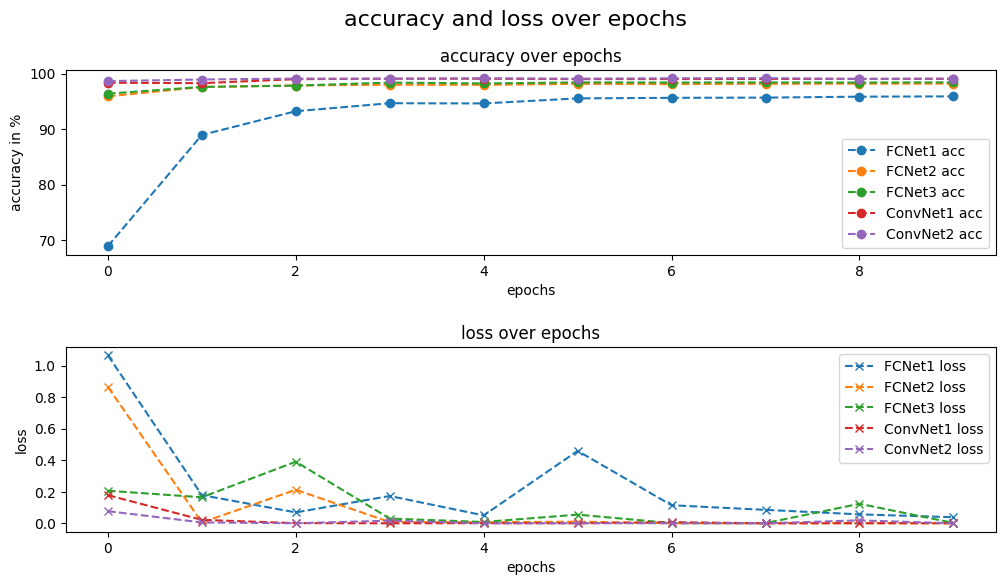

In [47]:
# def plotdata(gput:list, cput:list, gpuacc:list, cpuacc:list) -> None:
def plotdata(dataDict:dict,) -> None:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
    plt.subplots_adjust(wspace=0.5,hspace=0.5)

    fig.suptitle('accuracy and loss over epochs', fontsize=16)

    for model in dataDict:
        ax1.plot(dataDict[model]['acc'], 'o--',  label=f'{model} acc')
        ax2.plot(dataDict[model]['loss'], 'x--',  label=f'{model} loss')

    ax1.set_title("accuracy over epochs")
    ax1.set_ylabel("accuracy in %")
    ax1.set_xlabel("epochs")

    ax2.set_title("loss over epochs")
    ax2.set_ylabel("loss")
    ax2.set_xlabel("epochs")

    ax2.legend()
    ax1.legend()
    plt.savefig("Model_Vergleich.png")

with open("data.json", 'r') as json_file:
    data = json.load( json_file)

plotdata(dataDict=data)